# Project 1 - Handwriting Classification using a Deep Neural Network

This project will act as either an introduction or a refresher on plain Deep Neural Networks, going through the step-by-step process of how the feed-forward and backpropagation processes work and how a neural network trains itself to classify handwriting data.

This dataset here is the MNIST handwriting dataset which consists of several $28 \times 28$ pixel images of numbers ranging from $0$ to $9$. We will be working on building a model that can classify these images from scratch.

The CSV files for these are not included in the github version of this code due to github's lame 200mb file limit thingy. They can be downloaded from [here](https://pjreddie.com/projects/mnist-in-csv/) if you want to run the code. Placing them in the `dataset` folder will ensure it works as expected.

## What are, and how do Neural Networks work?

We already know how classical machine learning algorithms use a single function or algorithm such as linear regression, logistic regression, decision trees and so on to train on a dataset to perform a prediction. In these cases, the datasets we work with are fairly straightforward with only a few parameters to work with and whose tentative solutions that can fairly clearly be observed and modelled.

However, a lot of implementations exist where such models are just not enough. Yes, these models are useful for a lot of general use cases but for cases such as studying X-ray images, speech synthesis, and so on, more complex model architectures are necessary.

Neural networks work well when there are a large number of examples to work with as these models work by learning certain features of the inputs with every layer of the network piecewise, putting them together towards making a final prediction.

A basic NN model would look something like 

<img src="images/DNN1.jpg" width="800px">

#### Essential architectural parts of a neural network

- **Input layer**: Here , $x_1,x_2,\dots$ form the very first layer of the network, known as the input layer. These are usually in the form of matrices of information (as is the case for a lot of ML models) that are fed into the network to be processed. Each of the arrows in the image above represent a transfer of information between nodes/layers.
- **Nodes**: Each node of a neural network represents a set of functions which perform actions on the inputs received from the previous layer to generate an output. The nodes are arranged in _layers_. 
- **Hidden Layers**: Except the inputs and the final layer, the intermediate layers of a neural network are known as hidden layers.  The number of nodes in each hidden layer, and the number of layers themselves contribute to the increase in complexity and training cost of the neural network.
- **Output layer**: The final layer of the network that gives us the predictions our network makes on the input dataset is known as the output layer.

The basic idea of neural networks is taking different functions and chaining them together to form a composite function that can fit our data. If, say, $f^{(1)},f^{(2)},\text{and } f^{(3)}$ are the functions represented by 3 consecutive hidden layers of a neural network, then the composite function would be of the form $f(x) = f^{(3)}(f^{(2)}(f^{(1)}(x)))$.

The hidden layers get their name from the fact that they do not directly interact with either the inputs or outputs, hence not being exposed to the data in a direct manner.

Now, we will now look at the dataset we will be building our neural network upon. 

### Loading the packages and dataset

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

np.set_printoptions(threshold=sys.maxsize)

In [2]:
dev_data = pd.read_csv("./dataset/mnist_train.csv", header=None)
test_data = pd.read_csv("./dataset/mnist_test.csv", header=None)
dev_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
dev_data.shape

(60000, 785)

In [4]:
dev_data = np.array(dev_data) # this helps make this dataset easy to use by our model
test_data = np.array(test_data)

The dataset consists of $600000$ instances of $(28,28)$ pixel images of the given form

| Label | p00 | p01 | ... | p784 |
| --- | --- | --- | --- | --- |

where p00, p01, ... corresponds with the pixel's channel information starting from the upper left-hand side to the bottom right-hand side. Since the images are monochromatic, we work with only a single channel, hence giving us a 2 dimensional matrix to work with.

Below we can see what the images in our dataset looks like.

The Y value for this image is 6


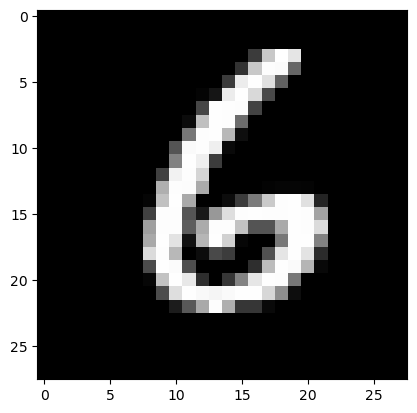

In [9]:
idx = 6000
sample_image = dev_data[idx][1:]
sample_image = sample_image.reshape((28,28))
print(f"The Y value for this image is {dev_data[idx][0]}")
plt.gray()
plt.imshow(sample_image)
plt.show()

In [6]:
dev_data1 = dev_data.T # This code is needed to split the data
test_data1 = test_data.T

The one hot encoder here converts the inputs of the final layer into a probability distribution for the softmax function. We will be looking into this later.

In [7]:
def one_hot_encoder(Y, labels):
    one_hot_shape = (Y.size, len(labels))
    one_hot_Y = np.zeros(one_hot_shape)
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

This code block generates the labels needed for our model to classify the information from the network into predictions in the softmax function at the output. It would normally be easy to just write out the numbers 0 to 9 for our inputs, but when generalizing a model like this, we will not know what all the labels are necessarily (and I am trying to avoid using in-built numpy functions as much as possible)

In [8]:

Y_dev = dev_data1[0]
X_dev = dev_data1[:][1:]
X_dev = X_dev / 255.
# Y_dev.shape = (1,60000)
Y_dev

Y_test = test_data1[0]
X_test = test_data1[:][1:]
X_test = X_test / 255.
# Y_test.shape = (1,10000)

labels = set(list(Y_dev.T) + list(Y_test.T))
labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(784, 60000)
(60000,)
(784, 10000)
(10000,)


Here, the dev and test labels are converted to probability distributions for our model to use as the output.

In [10]:
Y_dev_encoded = one_hot_encoder(Y_dev, labels)
Y_test_encoded = one_hot_encoder(Y_test, labels)
pprint(Y_dev_encoded[:,0]) # accessed by columns

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [11]:
print(X_dev.shape)
print(Y_dev_encoded.shape)
print(X_test.shape)
print(Y_test_encoded.shape)

(784, 60000)
(10, 60000)
(784, 10000)
(10, 10000)


Now that we have loaded up our dataset and set up its labels so that our network can work on it, we can now discuss a bit more about neurons and how this network is supposed to train

## Computing the outputs of a Node

Every node of a neural network performs two actions on the inputs to obtain the output. Taking the sigmoid function as an example, we get the following structure for a node.

<img src="images/LogRegRepresentation.jpg" width="600px">

The two steps of calculations being performed are:

- Computing the linear part
  
  $z^{[l]} = w^{[l]T}X + b^{[l]}$
- Computing the activation part
  
  $a^{[l]} = \sigma(Z^{[l]})$

Here, $w$ and $b$ refer to the weights and biases of the current node depicted by superscript $[l]$ which are acting on the inputs $X$. In practice the value of $Z^{[l]}$ is calculated as a vector as follows

$$
Z^{[1]} = \begin{bmatrix}
z_{1}^{[1]} \\
z_{2}^{[1]} \\
z_{3}^{[1]} \\
z_{4}^{[1]}
\end{bmatrix} =
\begin{bmatrix}
\dots & w_{1}^{[1]T} \dots \\
\dots & w_{2}^{[1]T} \dots \\
\dots & w_{3}^{[1]T} \dots \\
\dots & w_{4}^{[1]T} \dots
\end{bmatrix}
\cdot
\begin{bmatrix}
x_{1} \\
x_{2} \\
x_{3}
\end{bmatrix} +
\begin{bmatrix}
b_{1} \\
b_{2} \\
b_{3} \\
b_{4}
\end{bmatrix}
$$

$$
a^{[l]} = \sigma(Z^{[l]})
$$

## Activation Functions

Calculations in a neural network look something like

$$
\begin{align*}
z^{[1]} &= W^{[1]}x + b^{[1]}\\
a^{[1]} &= g^{[1]}(z^{[1]})\\
z^{[2]} &= W^{[2]}a^{[1]} + b^{[2]}\\
a^{[2]} &= g^{[2]}(z^{[2]})\\
\end{align*}
$$

where $g$ is the activation function. Some commonly used activation functions are
- **sigmoid**:
  - $a = \frac{1}{1+e^{-z}}$
  - Value Range: $[0,1]$
  - Used for binary classification
- **ReLU**:
  - $a = max(0,z)$
  - Value Range: $[-1,1]$
- **tanh**:
  - $a = tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}$
  - Value Range: $[0,\infty]$

The dataset in this case has multiple outputs, which makes this a multiclass classification problem. Hence, using a sigmoid function on the output is a no-go. We will, for this use case, make use of a softmax function on the output layer.

### The Softmax function
[Source](https://www.parasdahal.com/softmax-crossentropy)

Since our dataset consists of handwritten numbers from 0 to 9 that need to be classified, using a sigmoid function is not feasible as it only gives us an output of 0 or 1. For such a use case, we have the **Softmax** function. As the name suggests, it is a "soft" version of the argmax function where, instead of selecting a single maximum value, it divides it into a probability distribution, with the element with the maximum value having a large portion.

The formula for this function is given as
$$g(Z_{i}) = \frac{e^{Z_{i}}}{\sum\limits_{k=1}^{N}e^{Z_{k}}}$$

As you can see from the above explanation, this would be perfect for probabilistic interpretations. Hence, this is what we will be using on our output layer.

An easy way to think of the softmax function is a general form of the logistic regression function.

#### Loss function for the softmax
[Source](https://stackoverflow.com/questions/58461808/understanding-backpropagation-with-softmax)

#### Defining our activation functions

Here we define activation functions that will be used in the neurons for the forward and backward propagation process.

The cache here stores values that will be made use of during the forward process from Linear->ReLU or Linear->Sigmoid and the backward processes.

[Reference for Cross Entropy Loss of Softmax](https://shivammehta25.github.io/posts/deriving-categorical-cross-entropy-and-softmax/)

In [12]:
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def softmax(Z):
    # exps = np.exp(Z - np.max(Z))
    exps = np.exp(Z)
    A = exps / np.sum(exps, axis=0, keepdims=True)
    # print(Z.shape)
    # pprint(Z[:,0].shape)
    # print(f"A, {A}, {np.sum(A)}")
    # print(f"Z, {Z}")
    # print(f"A, {A} {np.sum(A)}")
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s, _ = sigmoid(Z)
    dZ = dA*s*(1-s)
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    s, _ = relu(Z)
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0 # relu clamps values of Z less than 0 to 0, this applies to dZ too
    assert (dZ.shape == Z.shape)
    return dZ

def softmax_backward(dA, cache):
    Z = cache
    s,_ = softmax(Z)
    # dZ = s*(1-s)
    dZ = np.array(dA, copy=True)
    assert (dZ.shape == Z.shape)
    return dZ

# def softmax_backward(dA, cache):
#     Z = cache
#     s, _ = softmax(Z)

In [13]:
# Z = np.array([[-0.0027147, 0.02011196, 0.017917, 0.00470983, -0.00322835, -0.02128286,
#   0.03631808, -0.01928523, -0.00042934, 0.00055172],[-0.0027147, 0.02011196, 0.017917, 0.00470983, -0.00322835, -0.02128286,
#   0.03631808, -0.01928523, -0.00042934, 0.00055172],[-0.0027147, 0.02011196, 0.017917, 0.00470983, -0.00322835, -0.02128286,
#   0.03631808, -0.01928523, -0.00042934, 0.00055172],[-0.0027147, 0.02011196, 0.017917, 0.00470983, -0.00322835, -0.02128286,
#   0.03631808, -0.01928523, -0.00042934, 0.00055172]])
# # pprint(Z)
# Z = Z.T
# # pprint(Z)
# pprint(Z.shape)
# A, _ = softmax(Z)
# print(Z)
# print(A,np.sum(A, axis=0))

## Defining helper functions for parameter initialization

For a Deep Neural net, it is important to ensure that our weights and biases are initialized appropriately. For the weights, we use random inputs and for the biases we can either use random values or zero vectors.

The function will take the layer dimensions that we define and accordingly generate the initial wight and bias values for each hidden layer.

Say for example we have the hidden layer dimensions as `[5,4,2,1]`. Then for the first layer we would get the weights in the form of a matrix with the dimensions being `(n_current, n_prev)`.

In [14]:
def initialize_parameters(layer_dims):
    np.random.seed(420)
    parameters = {}
    L = len(layer_dims) # this is the number of hidden layers

    # The for loop below generates weight matrices and bias vectors for each layer 
    for l in range(1, L):
        parameters["W"+ str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters["b"+ str(l)] = np.zeros((layer_dims[l],1))
    return parameters

# How neural networks train

The training of a neural network is split into two parts:

1. The **forward propagation** or **forward prop** part which involves feeding the input data through the neural network to generate the output prediction. When initially running this part the outputs we get will not have a good level of accuracy due to the weight and bias parameters being random. Now is where the second part comes into play.

2. **Backward Propagation** or **Backprop**. In this part, we calculate the gradient of the loss of the activation functions at each layer, starting from the output, making our way back to the first layer of the network. Gradent based algorithms such as gradient descent, momentum and Adam Prop are used to calculate the errors and update the weights appropriately such that the output predictions being made by the network eventually improve in accuracy.

## Forward Propagation

We will now look into the forward propagation process and develop the helper functions for the same.

The forward propagation process involves two main parts:
- the linear part
- the forward propagation of linear->activation part

The **Linear Forward** part in its vectorized form computes:

$$
Z^{[l]} = W^{[l]}A^{[l-1]}+b^{[l]}
$$

where $l$ is the current layer being worked on, $A^{[l-1]}$ is the activation from the previous layer, $W^{[l]}$ is the weight matrix and $b^{[l]}$ is the bias vector.

In the case of the very first layer, we would see that the previous activation would be none other than the inputs $X$, i.e. $a^{[0]}=X$.

The linear part of the function here will have the weight and bias vectors and the activations of the previous layer as the inputs.

In [15]:
def linear_part_forward(A_prev, W, b):
    cache = (A_prev, W, b) # this cache will be used for the back propagation process
    # print(f"(W,A,b) = {W.shape}, {A_prev.shape}, {b.shape}")
    Z = np.dot(W,A_prev)+b
    return Z, cache

Next is the **Linear Activation** part where we take the value generated by the linear part and input it into our activation function (linear -> activation). This would be
$$
A^{[l]} = g^{[l]}(Z^{[l]})
$$

Here, the output will be the $A$ value generated along with the cache which is a combination of the caches from the linear part and the activation functions. 

In [16]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_part_forward(A_prev, W, b)
    if activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    if activation == 'relu':
        A, activation_cache = relu(Z)
    if activation == 'softmax':
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

Putting these together the complete **Forward propagation** process will be performed by the function below.

In [17]:
def forward_propagation(X, parameters):
    caches = [] # list of caches for each layer
    A = X
    L = len(parameters) // 2 # the number of layers. each layer as 2 parameters.

    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="softmax")
    caches.append(cache)
    assert(AL.shape == (10,X.shape[1]))
    return AL, caches


## Backward Propagation

Now that forward propagation helper functions have been defined, we need to compare the outputs with the computed loss function to update our parameters. This is again done in three steps
- Computing the cost function
- The backward propagation of the linear part
- The linear -> activation backward propagation

in these cases we want to find the values of $dW^{[l]}$, $db^{[l]}$ and $dA^{[l-1]}$ given that we already know $dZ^{[l]}$.

The **linear part** for a given layer is
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
given that we have calculated $dZ^{[l]}$, we want to obtain the values for $dW^{[l]},db^{[l]},dA^{[l-1]}$. Hence, the linear part of the backward propagation finds these values in the following manner.
$$dW^{[l]} = \frac{1}{m}dZ^{[l]}A^{[l-1]T}$$
$$db^{[l]} = \frac{1}{m}\sum\limits_{i=1}^{m}dZ^{[l](i)}$$
$$dA^{[l-1]} = W^{[l]T}dZ^{[l]}$$

In [18]:
def linear_part_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

The **Linear Activation backward**, as the name suggests, perfroms the backward step for the activation. This makes use of the helper functions defined previously, taken here as $g(.)$ to compute 
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) = A^{[l]} - Y$$

In this case, as we are taking the quadratic cost function
$$J = \frac{1}{2m}\sum\limits_{X}||A^{[l]} - Y||^{2}$$
where $m$ is the number of training examples.

So the value of $dZ^{[l]}$ would be
$$dZ^{[l]} = A^{[l]} - Y$$

In [19]:
# Here dA is the prediction at the current layer, cache holds the linear and activation caches,
# and activation tells us the type of activation function being worked on at the given node
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_part_backward(dZ, linear_cache)
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_part_backward(dZ, linear_cache)
    if activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_part_backward(dZ, linear_cache)

    return dA_prev, dW, db

Putting these together we get the **Backward Propagation part**.

In [20]:
# def cost_derivative(AL, Y):
#     return AL-Y

def backward_propagation(AL, Y, labels, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    # Y = Y.reshape(AL.shape)

    # Here we take J= 1/2 * (Y - A)^2 for the output layer
    dAL = AL - Y
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dA=dAL, cache=current_cache, activation="softmax")

    # Computing the cost derivatives for layers L-1 to 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA=grads["dA" + str(l+1)], cache=current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
    return grads


# Computing the Cost

[Reference](https://medium.com/intuition/a-neural-network-with-pure-numpy-d44d2632e9a0)

We will also need the cost to track how well the training propagation process is going. The cost function for the softmax function is in the form of Cross Entropy Loss, given by
$$
L = - \frac{1}{m}\sum\limits^{m}_{i=1}y_{i}\cdot\log{\hat{y}_{i}}
$$
we define the function for the same below

In [21]:
def compute_cost(AL, Y, labels):
    m = Y.shape[1]

    # Compute loss from aL and y.
    # pprint(np.array(AL - Y)[:,0])
    assert(AL.shape == Y.shape)
    # cost = (1/(2*m)) * np.sum(np.power(AL - Y, 2))
    cost = - (1/(m)) * np.sum(Y * np.log(AL))
    cost = np.squeeze(cost)
    
    return cost

# Updating the parameters

Now that we have the derivatives for all the layers, we can now update each of the parameters at hand. This is done so as
$$\theta^{[l]} := \theta^{[l]} - \alpha d\theta^{[l]}$$
where $\alpha$ is the learning rate and $\theta$ refers to the parameter being updated.


In [22]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of  layers
    for l in range(1,L+1):
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate*grads["dW"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate*grads["db"+str(l)]
    return parameters

Hence, it is with the iterative running of forward and backward propagation one after the other, followed by updating the parameters at each step in a controlled manner via the learning rate, that we train our model to eventually get better at making predictions on new data based on the pre-existing input data.

We now define functions to get predictions from the model developed. Using this we can see how our model performs at each step vis the accuracy

In [23]:
def get_predictions(AL):
    # Since we are dealing with numbers from 0 to 9, argmax will return the
    # index of the softmax output with the maximum probaility, which will
    # coincide with the predicted label
    return np.argmax(AL, axis=0, keepdims=True)

def get_accuracy(AL, Y):
    predictions = get_predictions(AL)
    return (np.sum((predictions == Y)) / Y.size) * 100

# The model
Here we will use all the helper functions defined to create our model and train it.

In addition to this, we will use a  `predict()` function to perform predictions on an evaluation set

In [24]:
def mnist_model(X, Y, Y_encoded, labels, layer_dims, learning_rate = 0.5, num_iterations = 3000, print_cost=False, stop_at=0, wait_for=10):
    np.random.seed(420)
    costs = []
    accuracies = []
    parameters = initialize_parameters(layer_dims)
    iter_wait = 0 # Tracks up to 3 iteration for which the accuracy is higher than a value determined by stop_at
    for i in range(num_iterations):
        # Forward Propagation
        AL, caches = forward_propagation(X, parameters)

        # Getting the predictions for the given 
        accuracy = get_accuracy(AL,Y)

        # Computing the cost
        cost = compute_cost(AL, Y_encoded, labels)
        
        # Backward Propagation
        grads = backward_propagation(AL, Y_encoded, labels, caches)

        # Updating parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 50 == 0:
            print(f"Cost after iteration {i}: {cost}")
            print(f"Accuracy after iteration {i}: {accuracy}%")
            # print(AL[:, 0], np.sum(AL[:, 0]))
            # print(AL[:, 9], np.sum(AL[:, 0]))
            # print(Y[:, 9])
        if print_cost and i % 10 == 0:
            costs.append(cost)
            accuracies.append(accuracy)
        if stop_at !=0 and accuracy > stop_at:
            iter_wait += 1
            if iter_wait == wait_for:
                break
            else:
                iter_wait = 0

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(np.squeeze(costs), label="Cost", color="r")
    ax2.plot(np.squeeze(accuracies), label="Accuracy", color="g")
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Costs')
    ax2.set_ylabel('Accuracies')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend(loc="upper right")
    plt.show()
    
    return parameters

# Training our Model

Now that our model is ready, we will train it on the MNIST dataset. For this, we need to load up the dataset and make sure it is in a form that can be used by our model.

The original dataset from the [original site](http://yann.lecun.com/exdb/mnist/) is not accessible to us anymore. Hence we will be working with the dataset from [here](https://pjreddie.com/projects/mnist-in-csv/) which is a CSV containing the pixel information for all the images

When training our network, the input layer will take in the pixel information for the images, which is 784 in number, followed by the hidden layers and the output layer, which will have 10 nodes with the activation function being the softmax function.

In [25]:
layer_dims = [784,64,32,10,10]

Cost after iteration 0: 2.306602245211194
Accuracy after iteration 0: 12.0%
Cost after iteration 50: 1.644898531234305
Accuracy after iteration 50: 39.025%
Cost after iteration 100: 0.613450593163509
Accuracy after iteration 100: 78.14166666666667%
Cost after iteration 150: 0.4104928815184014
Accuracy after iteration 150: 88.04833333333333%
Cost after iteration 200: 0.21166680786056358
Accuracy after iteration 200: 93.77499999999999%
Cost after iteration 250: 0.17302160411523618
Accuracy after iteration 250: 94.77499999999999%
Cost after iteration 300: 0.16033286714656234
Accuracy after iteration 300: 95.265%
Cost after iteration 350: 0.13122115386519861
Accuracy after iteration 350: 96.08%
Cost after iteration 400: 0.1459034910417827
Accuracy after iteration 400: 95.61333333333333%
Cost after iteration 450: 0.11895881486378244
Accuracy after iteration 450: 96.40333333333334%
Cost after iteration 500: 0.107826149787028
Accuracy after iteration 500: 96.79333333333334%
Cost after iterati

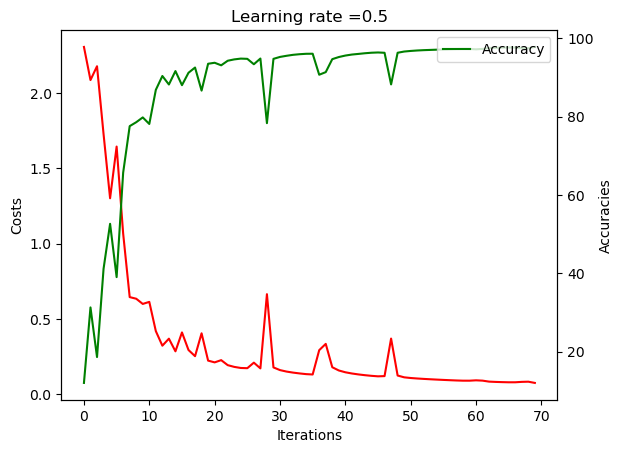

In [26]:
nn_model = mnist_model(X_dev, Y_dev, Y_dev_encoded,labels,layer_dims,learning_rate=0.5,num_iterations=1000, print_cost=True, stop_at=97.8, wait_for=1)

In this example, with some experimentation, I found that the dimensions $$[784,64,32,10,10]$$ work pretty decently. Here, the first and last two dimensions are meant to be fixed as they are the inputs and output softmax layer respectively.

Regularization strategies and other optimization strategies could be implemented here to help with the accuracy and training speed (as you can see it's miserably slow), but for this example, let's just stick to a simple neural network.

# Model Evaluation

We will now evaluate the model we have trained by using it to make predictions on some unknown data. For this we have a completely separate test dataset consisting of 10000 images with the same dimensions as before.

Given below are the two functions to help with making the predictions and displaying the images and the model outputs.
```python
def predict()
  ...
  return predictions, accuracy

def show_prediction()
  ...
  # Displays the image and the predicted label based on the index
```

In [27]:
def predict(X, Y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((10,m))

    # to make predictions, we just need to do one run of forward propagation
    # with the parameters from our trained model
    # AL here is basically a set of probabilities for each possible digit,
    # hence the name probs
    probs, _ = forward_propagation(X, parameters) 
    predictions = get_predictions(probs)
    accuracy = get_accuracy(probs, Y)

    return predictions, probs, accuracy

In [28]:
predictions, probabilities, accuracy = predict(X_test, Y_test, nn_model)
print(f"The model accuracy is {accuracy}")

The model accuracy is 96.99


Here we can see that our model has managed to get an accuracy of 96.18 on the testing data. With a bit of tinkering we can manage to get this value  up to $98\%$

In [29]:
def show_prediction(X, Y, predictions, probabilities, index = 0):
    sample_image = X[:,index]
    sample_image = sample_image.reshape((28,28))
    print(f"The model predicted a value of {np.squeeze(predictions[:,index])} for the given image. The actual value is {Y[index]} \n")
    print(f"The probabilities for the given prediction are\n")
    # print(probabilities[:, index])
    
    fig = plt.figure()
    plt.gray()
    plt.imshow(sample_image)
    plt.show()

    fig1 = plt.figure()
    plt.bar(x=range(len(probabilities[:, index])),height=probabilities[:, index])
    plt.xticks(range(len(probabilities[:, index])))
    plt.xlabel("Label")
    plt.ylabel("Probability value")
    plt.show()

The model predicted a value of 0 for the given image. The actual value is 0 

The probabilities for the given prediction are



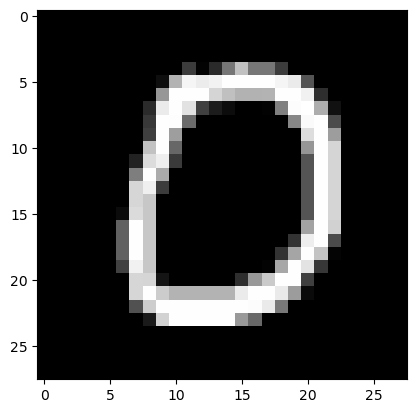

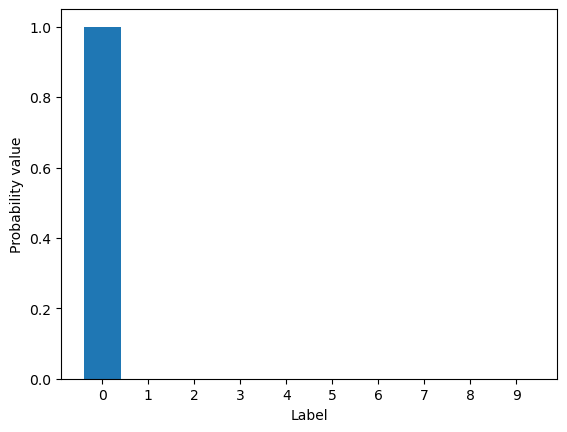

In [30]:
show_prediction(X_test, Y_test, predictions, probabilities, index=10)

# An experiment to see what the network is learning

Now, I could just leave it here but I am curious to see what the network is learning in this case, particularly to visualize it.

In [31]:
nn_model['W1'].shape

(64, 784)

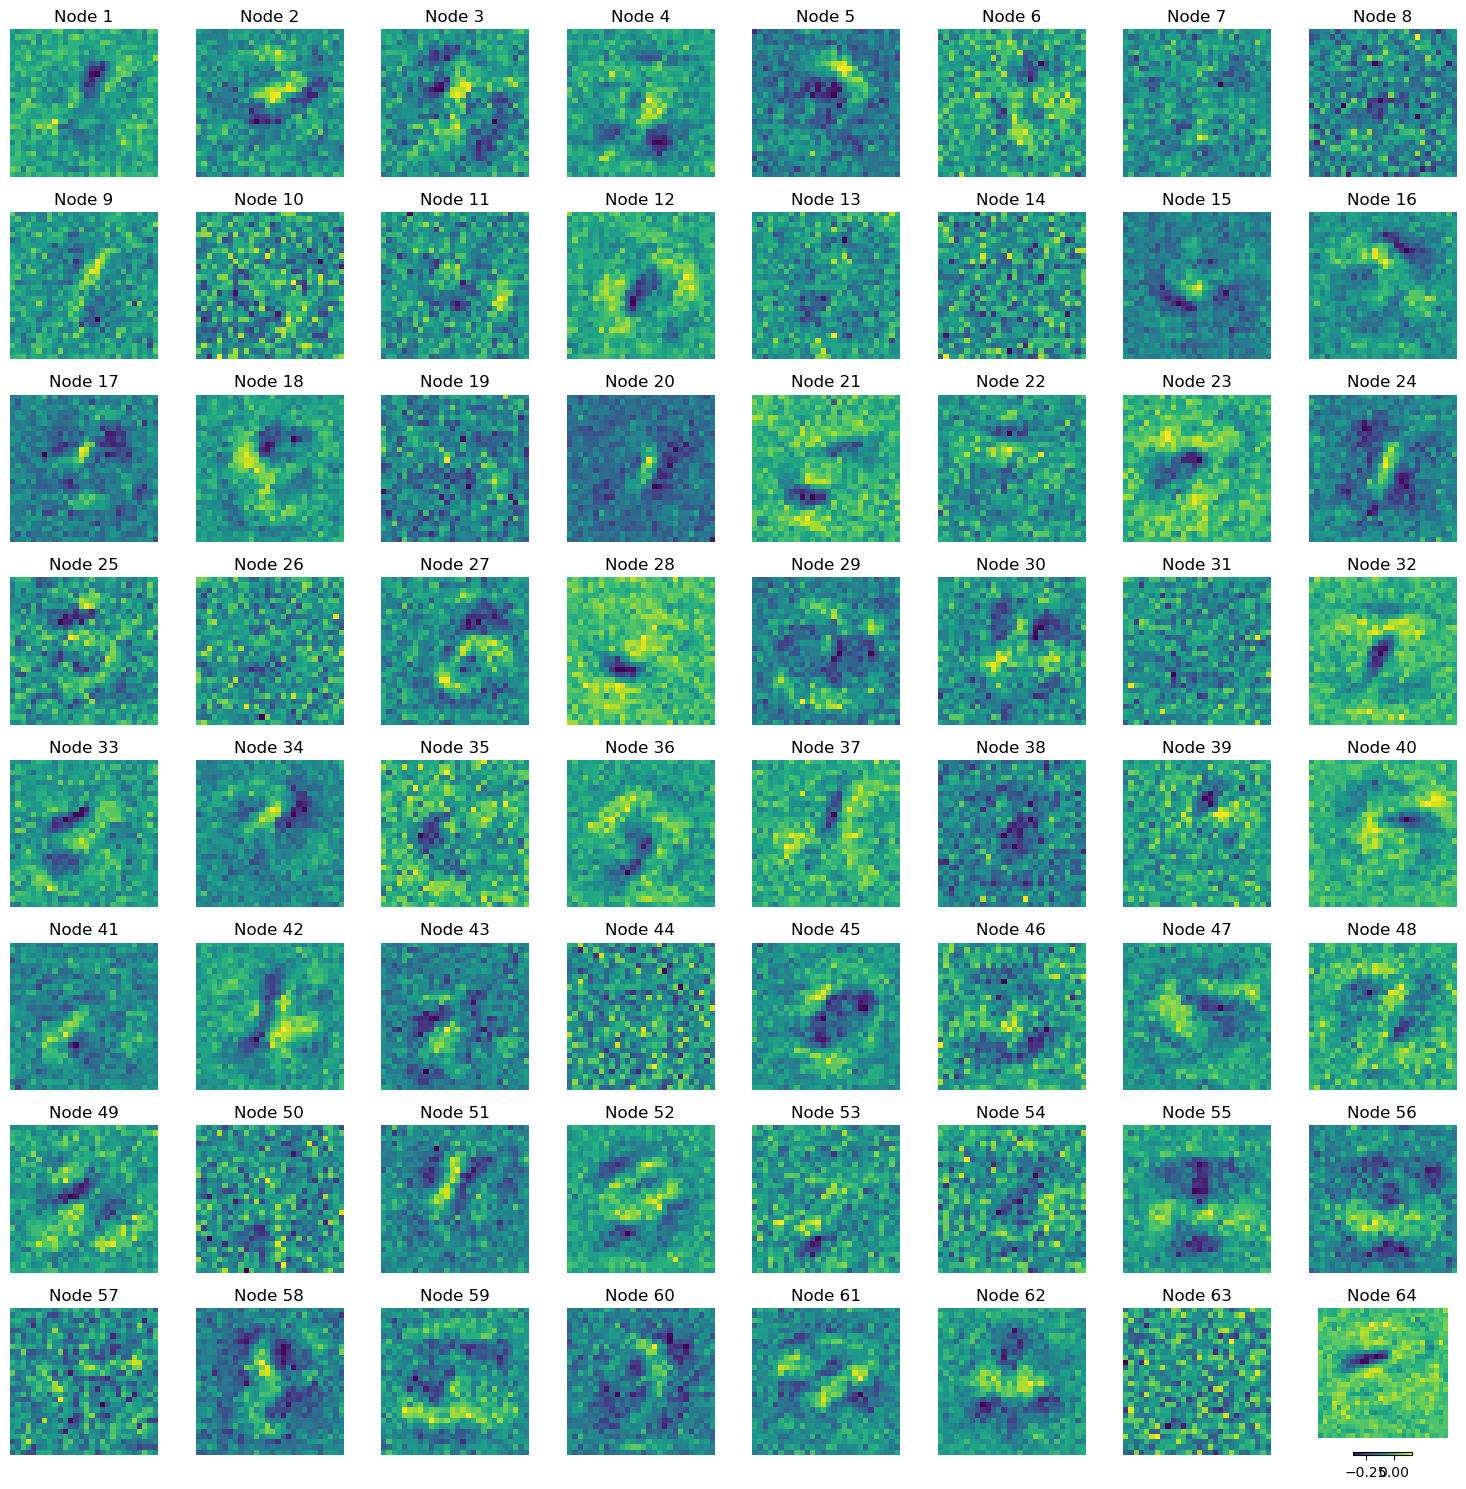

In [32]:
values = nn_model['W1']

fig, ax = plt.subplots(8,8,figsize=(15,15))

for i, ax in enumerate(ax.flat):
    if i < values.shape[0]:
        heatmap_data = values[i].reshape(28, 28)
        heatmap = ax.imshow(heatmap_data, cmap='viridis')
        ax.set_title(f'Node {i+1}')
        ax.axis('off')

fig.colorbar(heatmap, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout()
plt.show()

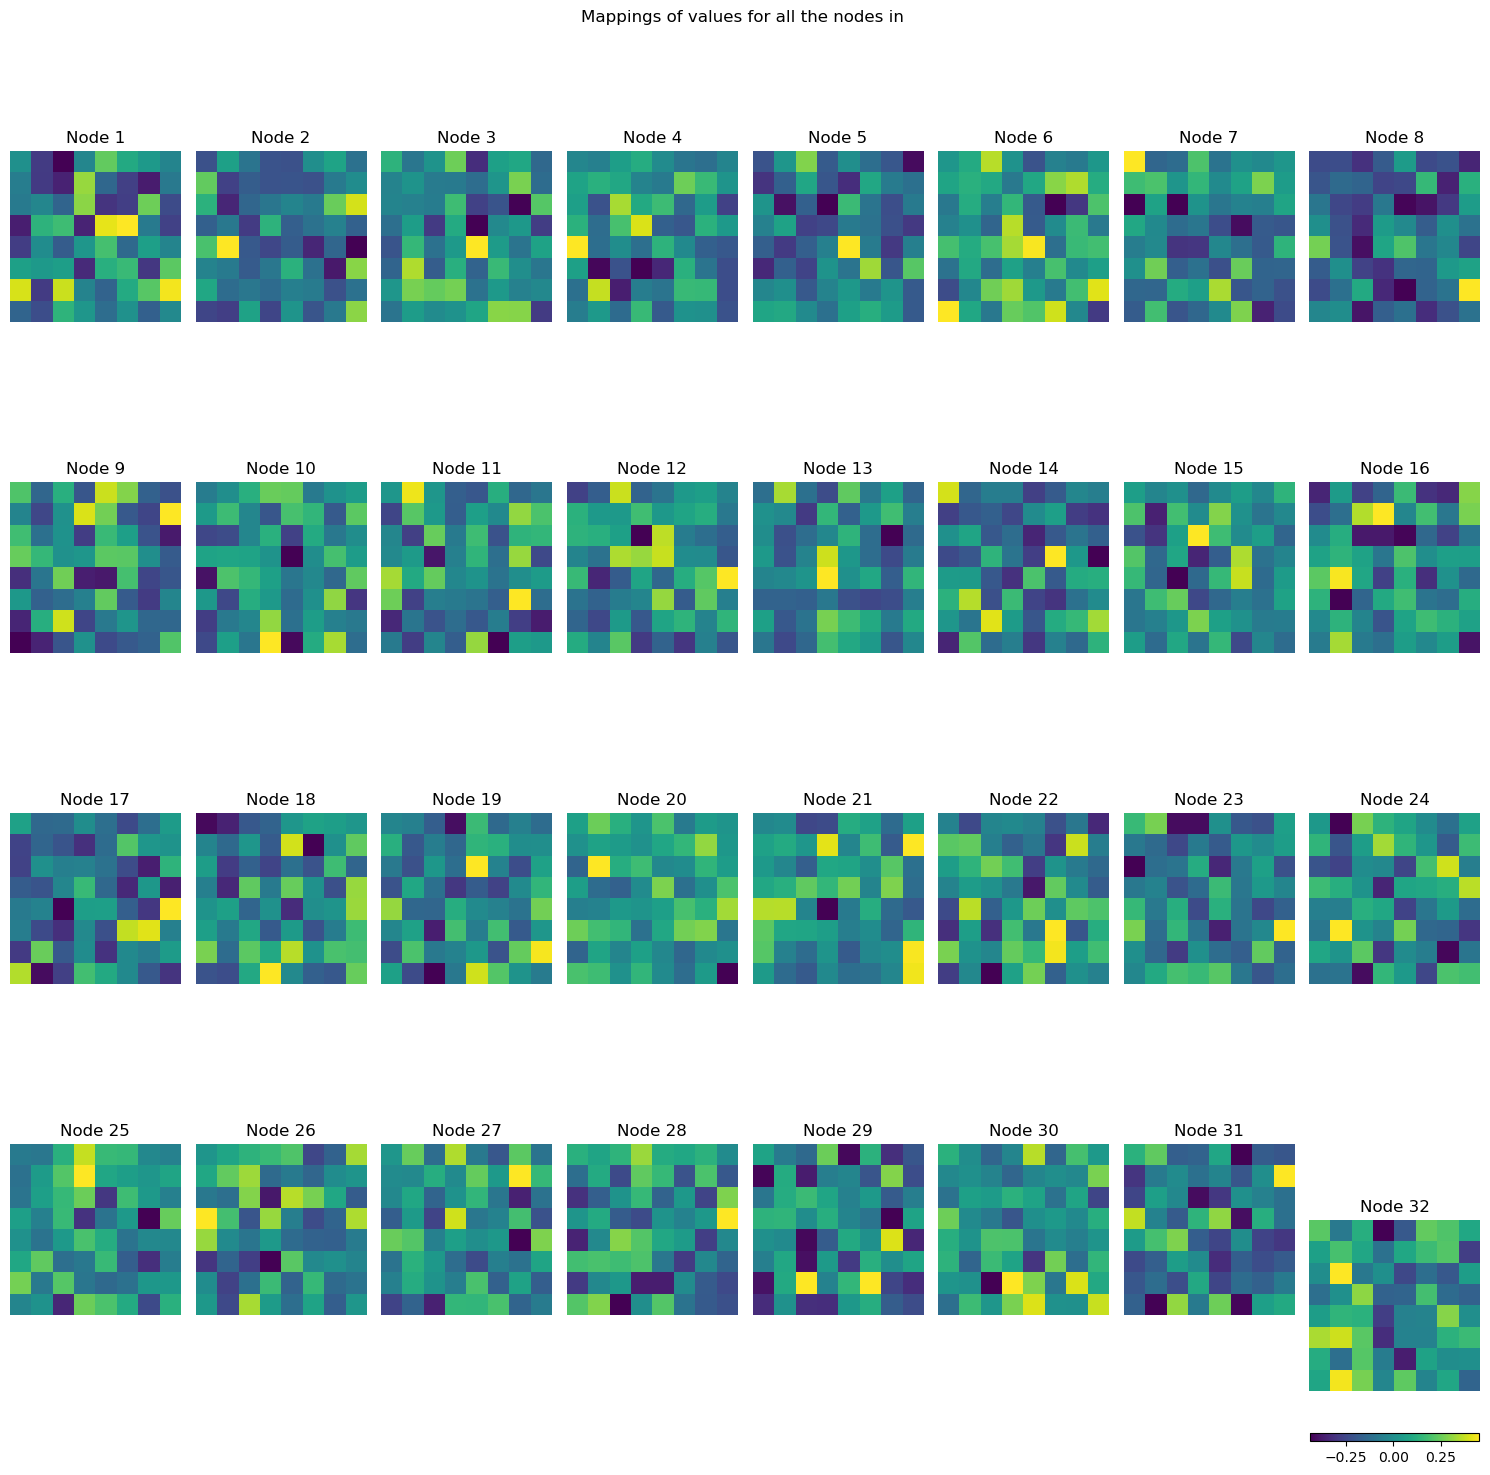

In [37]:
values = nn_model['W2']

fig, ax = plt.subplots(4,8,figsize=(15,15))

fig.suptitle("Mappings of values for all the nodes in ")
for i, ax in enumerate(ax.flat):
    if i < values.shape[0]: 
        heatmap_data = values[i].reshape(8, 8)
        heatmap = ax.imshow(heatmap_data, cmap='viridis')
        ax.set_title(f'Node {i+1}')
        ax.axis('off')

fig.colorbar(heatmap, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout()
plt.show()

# Final Notes and observations
The basic working of this model, despite the complexity introduced by the softmax function, is the same as if we were to make a binary prediction using a sigmoid function as the output

Our model takes in 784 parameters, each corresponding to a pixel on the image input, with 60000 instances to train on. These parameters are then input to our first hidden layer, which in this case consists of 10 nodes. The activation function used here is ReLU. We could also use Tanh or Sigmoid functions here, but to make things a bit easy, we are sticking with ReLU.

The inputs are put through the forward propagation process where it finds the linear part $WX+b$, which is then used by our ReLU activation functions in each of the hidden layers' nodes to give us the first output.

This output is then taken as the input of our softmax function. The softmax function outputs a set of probabilities corresponding to the Z values from the preceding layer which is taken as the output for our model.

The backpropagation process uses the loss function to get the derivatives of the Losses with respect to the weights and biases at each layer. These are then used to update the weights and biases which are then used to train our model for a second time.

This process is repeated till we are satisfied with the outcome or it reaches the number of epochs input to the model. In this case, we have just taken the final output. 

The default layer dimensions used here are $[784,64,10,10]$ and the default random seed used is $420$. The first and last dimensions here are the input and output layers respectively, and the middle numbers refers to the hidden layer. More layers can be added to the model by adding the number of nodes you want at the respective position. However, make sure that the last two layers have the dimension of $10 \times 10$ as the softmax function requires the same number of inputs as the output.

Our model performs at an accuracy of 93.3% on the testing dataset. From the training graph, we see that the model reaches a valley pretty quickly at less than 10 epochs after which it plateaus, barely hovering about the 91-93% accuracy mark. We even see a few spikes in the training process, showing that the model is overshooting the minima by a large amount. Another factor to consider is that we are using a fairly large learning rate. Though this is good when it comes to reducing the training time, it can lead to the exploding gradient problem which we see before. Another thing to consider is that we are using standard gradient descent which is good but could lead to us being stuck at a local minima. Using other backpropagation optimization functions can help with this.

The above observations show that this model might not exactly be the most ideal one to use for handwriting recognition, however, it does do a pretty decent job at it. This is evidenced by how long the model takes to train and how there seems to be a bunch of glitches in the loss curves during the training process.. A solution for this can be more layers, lower learning rates, regularization and optimization strategies, or better yet, using a completely different architecture such as Convolutional Neural Networks, which are better built for this case.

TODO: Complete Visualizations at a later date.

# Visualisation of the learning process

Given below is a representation of how the model works.

In [34]:
from manim import *
import sys
import numpy as np
import pandas as pd

np.set_printoptions(threshold=sys.maxsize)
# import jupyter_manim
# from manimlib.scene.scene import Scene
# from manimlib.mobject.geometry import Circle
# from manimlib.animation.creation import ShowCreation

In [35]:
dev_data = pd.read_csv("./dataset/mnist_train.csv", header=None)
dev_data = np.array(dev_data)

In [ ]:
%%manim -qm TestAnimation

class TestAnimation(Scene):
    images = pd.read_csv("./dataset/mnist_train.csv", header=None)
    images = np.array(images)

    def construct(self):

        number_imagearray = self.images[9][1:]
        number_imagearray = number_imagearray.reshape((28,28))
        number_image = ImageMobject(np.asarray(number_imagearray)).move_to([0,1,0])
        number_image.set_resampling_algorithm(RESAMPLING_ALGORITHMS["nearest"])
        number_image.height = 4
        number_image.z_index = 0
        grid= NumberPlane(x_range=(0,28,1), y_range=(0,28,1), x_length=4, y_length=4, background_line_style={"stroke_opacity": 0.4})
        grid.move_to([0,1,0])
        grid.z_index = 1
        number_image.background_rectangle = SurroundingRectangle(number_image, GREEN_B, buff=0)
        number_image.background_rectangle.z_index = 2
        number_image_group = Group(number_image, number_image.background_rectangle, grid)

        zoom_line1 = Line


        image_desc1 = Tex("The Dataset: 60,000 28$\\times$28 pixel images of handwritten digits", font_size=40).move_to([0,-2,0])
        image_desc2 = Tex(f"Each pixel has a color value \\\\ ranging from 0 to 255", font_size=35).move_to([3,0,0])

        # Group(number_image_group, image_desc1).arrange(DOWN, buff=0.8)

        # square.next_to(circle, RIGHT, buff=0.5)  # set the position
        # self.add(image_group)
        self.play(LaggedStart(Create(number_image.background_rectangle), FadeIn(number_image), Write(image_desc1, run_time=0.5)))
        self.play(Create(grid))
        self.wait(2)
        self.play(Unwrite(image_desc1, run_time=0.5), number_image_group.animate.shift(LEFT*3, DOWN).scale(1.25))
        self.play(Write(image_desc2, run_time=0.5))
        self.wait(3)
        # self.play(number_image_group.animate.shift(LEFT*3).scale(0.4))